# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# **EDA**

In [ ]:
df = pd.read_csv('/content/train-5.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

In [ ]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
store_id = 7
item_id = 31
filtered_data = df[(df['store'] == store_id) & (df['item'] == item_id)]

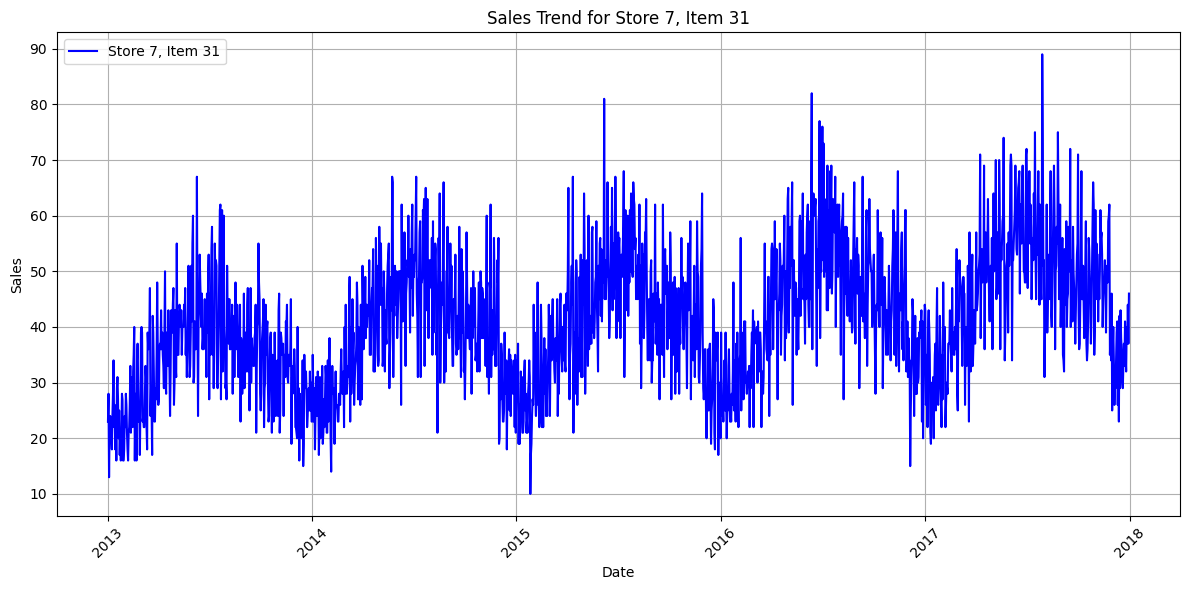

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(filtered_data['date'], filtered_data['sales'], label=f'Store {store_id}, Item {item_id}', color='blue')

plt.title(f'Sales Trend for Store {store_id}, Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


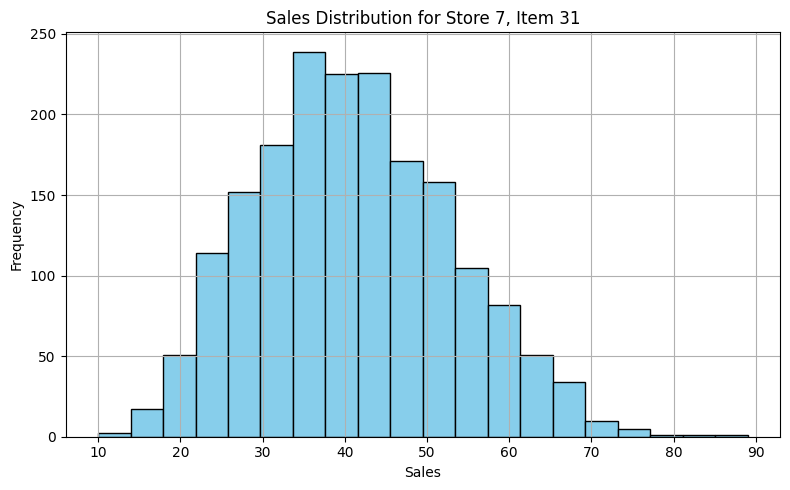

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(filtered_data['sales'], bins=20, color='skyblue', edgecolor='black')

plt.title(f'Sales Distribution for Store {store_id}, Item {item_id}')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.grid(True)
plt.tight_layout()
plt.show()

The **Sales Distribution** appears to be *Normally* distributed at around **40** sales value  with *moderate* spread across the board.

In [ ]:
df_monthly = filtered_data.resample('ME', on='date').sum()

<Axes: xlabel='date'>

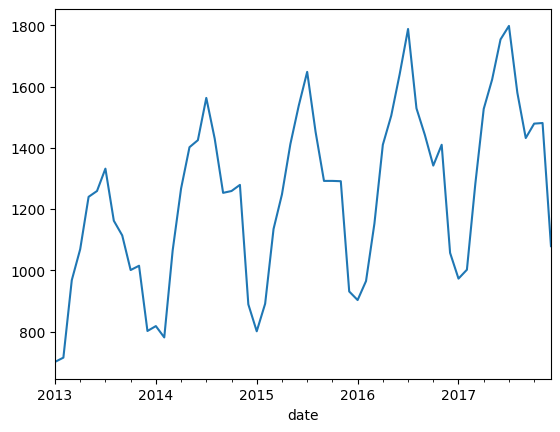

In [ ]:
df_monthly['sales'].plot()

Monthly sales over time suggests a **positive** trend with a distinct **seasonal pattern**. This implies *item 7* may be of seasonal nature with a growing demand. Further analysis is required.

# **Time Series Analysis**

## Dickey-Fuller Test

In [ ]:
result = adfuller(df_monthly['sales'])

adf_statistic = result[0]
adf_p_value = result[1]

print(f"ADF Statistic: {adf_statistic:.5f}")
print(f"P-value: {adf_p_value:.5f}")
if adf_p_value < 0.05:
    print("The time series is stationary (Reject the null hypothesis)")
else:
    print("The time series is non-stationary (Failed to reject the null hypothesis)")

ADF Statistic: -2.64801
P-value: 0.08348
The time series is non-stationary (Failed to reject the null hypothesis)


## Auto-Correlation & Partial Auto-Correlation Test

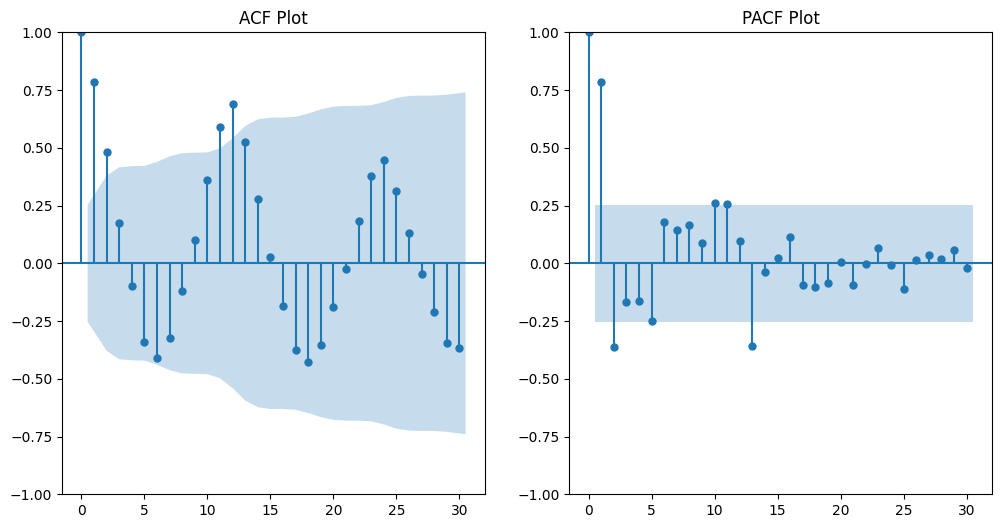

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df_monthly['sales'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df_monthly['sales'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.show()

* The **ACF** values *gradually decay*, suggesting a moving average component in the time series.

* The **PACF** plot shows significant spikes at multiple lag points with **no** clear cut-off

## Seasonal Decomposition Plotting

In [ ]:
result = seasonal_decompose(df_monthly['sales'], model='additive', period=12)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

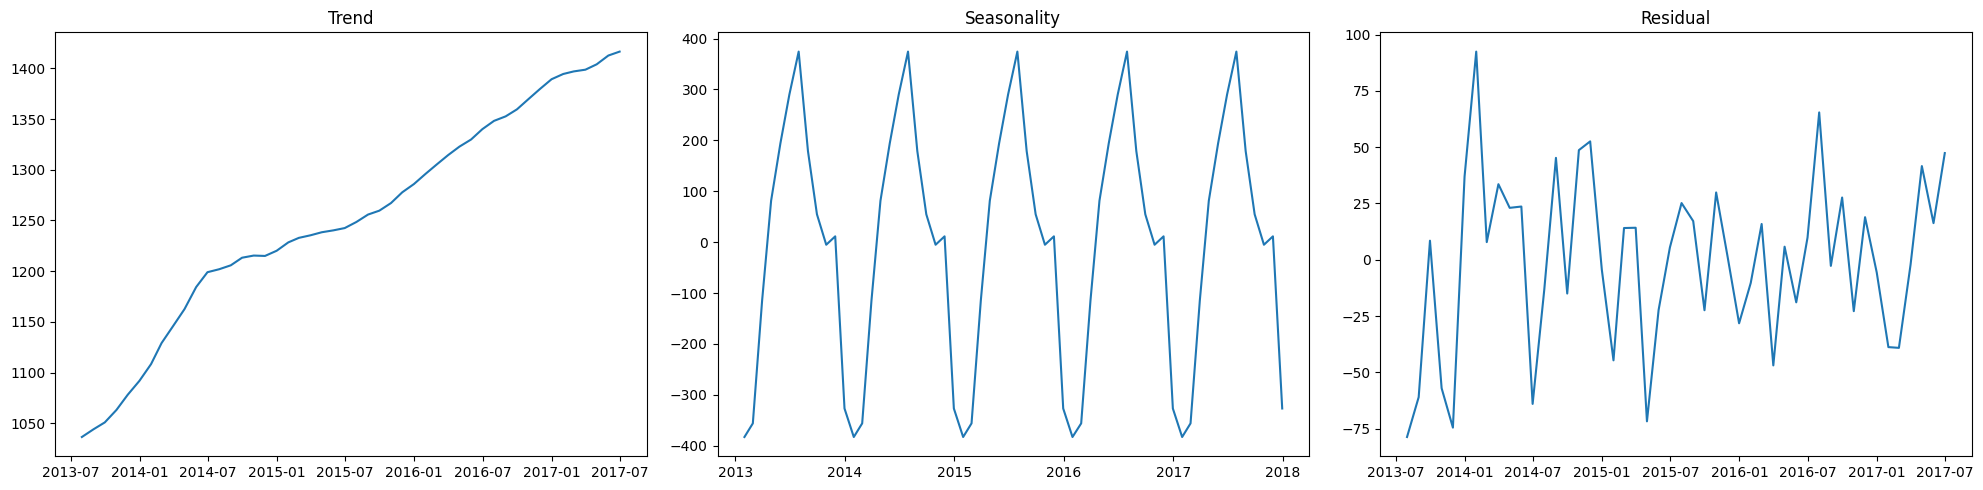

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) # Create a figure and 3 subplots

axes[0].plot(trend)
axes[0].set_title('Trend')

axes[1].plot(seasonal)
axes[1].set_title('Seasonality')

axes[2].plot(residual)
axes[2].set_title('Residual')

plt.tight_layout()
plt.show()

* There is a clear **upward** trend, indicating that sales have been **increasing** over time. The rate of increase seems to be generally **steady**.

* There is evidence of a **cyclical** pattern. However, the degree of seasonal fluctuations seem to be relatively stable.

* The residual component appears to be relatively **random**, with **no** clear pattern.  There are a few **noticeable** spikes in the residuals, which might indicate *outliers/anomalies*.

## Outlier Handling

In [ ]:
threshold = 2 * residual.std()
outliers = residual[abs(residual) > threshold]

print("Outliers found at:")
print(outliers)

Outliers found at:
date
2013-07-31   -78.703125
2014-01-31    92.421875
Name: resid, dtype: float64


In [ ]:
df_monthly['sales_clean'] = df_monthly['sales'].copy()
for idx in outliers.index:
    # Use pd.DateOffset to add/subtract time periods
    df_monthly['sales_clean'].loc[idx] = df_monthly['sales'].loc[idx - pd.DateOffset(days=1): idx + pd.DateOffset(days=1)].mean()

<ipython-input-15-39edc2b2e3b6>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_monthly['sales_clean'].loc[idx] = df_monthly['sales'].loc[idx - pd.DateOffset(days=1): idx + pd.DateOffset(days=1)].mean()
<ipython-input-15-39edc2b2e3b6>:4:

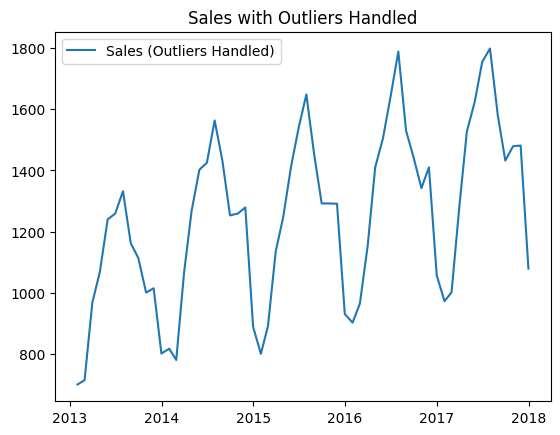

In [ ]:
plt.plot(df_monthly['sales_clean'], label='Sales (Outliers Handled)')
plt.title('Sales with Outliers Handled')
plt.legend()
plt.show()

## Removing Trend & Seasonality

via **First-order Differencing**

In [ ]:
df_monthly['sales_clean'] = df_monthly['sales_clean'].diff().dropna()

In [ ]:
df_monthly['sales_clean'][df_monthly['sales_clean'].isna()]

,sales_clean
date,
2013-01-31,NaN


In [ ]:
df_monthly['sales_clean'] = df_monthly['sales_clean'].fillna(df_monthly['sales_clean'].mean())

In [ ]:
df_monthly['sales_clean'][df_monthly['sales_clean'].isna()]

,sales_clean
date,


<Axes: xlabel='date'>

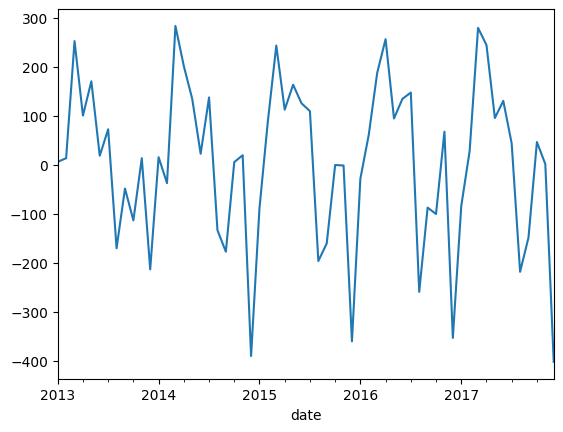

In [ ]:
df_monthly['sales_clean'] .plot()

The **first-order differencing** appears to have effectively removed the *trend* and *seasonal* components from the data.

### Time Series Analysis of **Stationary Data**

In [ ]:
adf_test = adfuller(df_monthly['sales_clean'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Interpretation
if adf_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is non-stationary")

ADF Statistic: -3.4395683707840856
p-value: 0.00968171124035231
The data is stationary


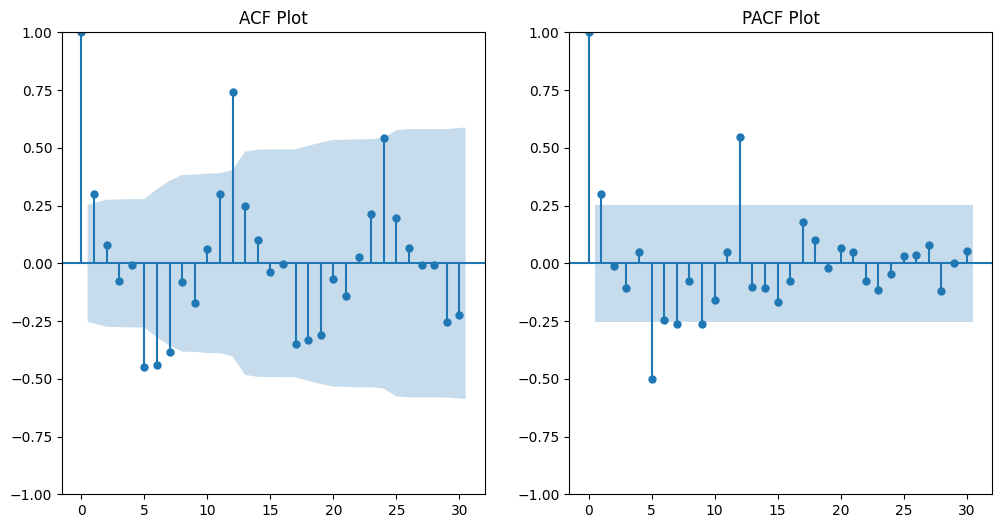

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df_monthly['sales_clean'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df_monthly['sales_clean'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.show()

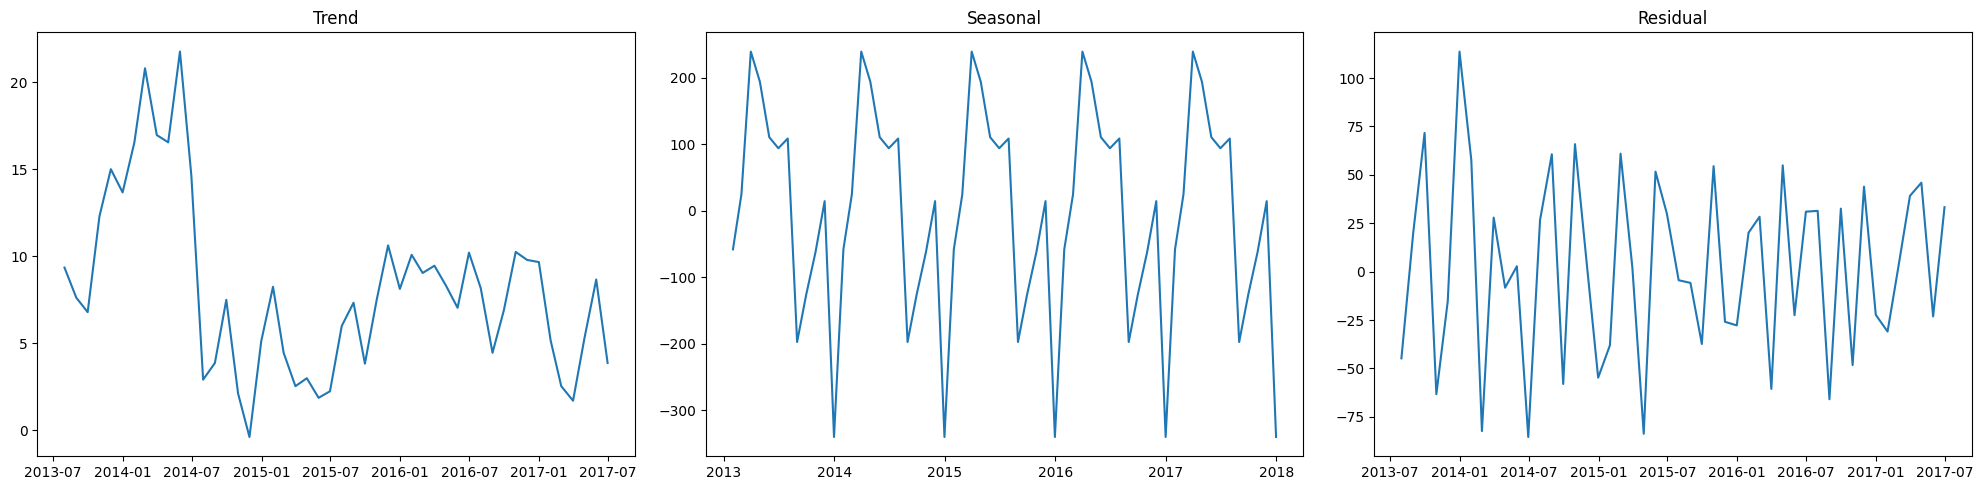

In [ ]:
result = seasonal_decompose(df_monthly['sales_clean'], model='additive', period=12)
trend = result.trend
seasonal = result.seasonal
residual = result.resid
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot on each subplot
axes[0].plot(trend)
axes[0].set_title('Trend')

axes[1].plot(seasonal)
axes[1].set_title('Seasonal')

axes[2].plot(residual)
axes[2].set_title('Residual')

plt.tight_layout()
plt.show()

# Train-Test Split

In [ ]:
def train_test_split(time_series, test_size=0.2):
    n = len(time_series)
    train_size = int(n * (1 - test_size))
    train, test = time_series[:train_size], time_series[train_size:]
    return train, test

In [ ]:
train, test = train_test_split(df_monthly['sales_clean'])

# **Time Series Modelling**

## **ARIMA** Model

In [ ]:
arima_order = (2, 1, 12) #Adjusted based on ACF/PACF plot
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **SARIMAX** Model

In [ ]:
sarimax_order = (2, 0, 1) #Adjusted based on ACF/PACF plot
seasonal_order = (1, 1, 1, 12)

sarimax_model = SARIMAX(train, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_fit = sarimax_model.fit()

sarimax_forecast = sarimax_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# **Analysing Predictions**

In [ ]:
results_df = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMAX Forecast': sarimax_forecast
})

print(results_df.head())

            Actual  ARIMA Forecast  SARIMAX Forecast
2017-01-31   -84.0       18.516618        -57.639258
2017-02-28    29.0       -4.202730         68.096341
2017-03-31   280.0       21.378562        215.133156
2017-04-30   245.0       64.741596        211.103861
2017-05-31    96.0       97.592689        115.136639


## Comparing Residuals

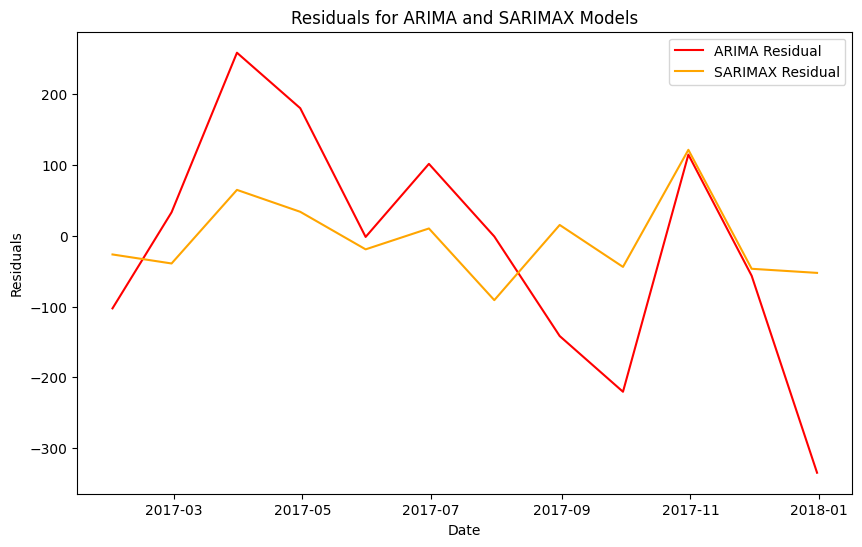

In [ ]:
results_df['ARIMA Residual'] = results_df['Actual'] - results_df['ARIMA Forecast']
results_df['SARIMAX Residual'] = results_df['Actual'] - results_df['SARIMAX Forecast']

# Plot residuals
plt.figure(figsize=(10, 6))

plt.plot(results_df.index, results_df['ARIMA Residual'], label='ARIMA Residual', color='red')
plt.plot(results_df.index, results_df['SARIMAX Residual'], label='SARIMAX Residual', color='orange')

plt.title('Residuals for ARIMA and SARIMAX Models')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## **Visualizing Forecasts**

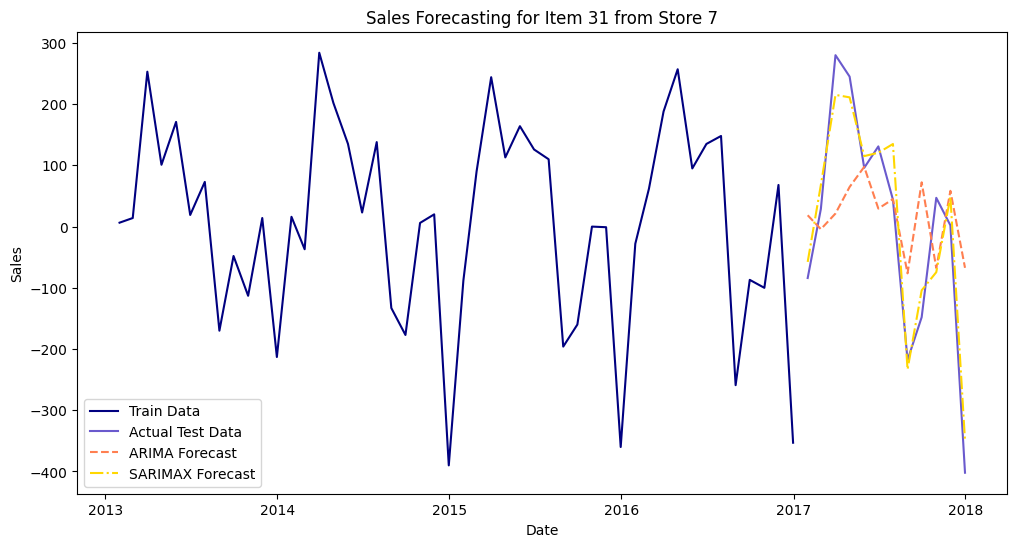

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the actual sales data
plt.plot(train.index, train, label='Train Data', color='navy')
plt.plot(test.index, test, label='Actual Test Data', color='slateblue')

plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='coral', linestyle= '--')

plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='gold', linestyle = 'dashdot')

plt.title(f'Sales Forecasting for Item {item_id} from Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()